<a href="https://colab.research.google.com/github/cs16677/ce888/blob/master/Lab7/CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
from zipfile import ZipFile
import shutil

os.environ['KAGGLE_USERNAME'] = "harrystafford"
os.environ['KAGGLE_KEY'] = "be089b0d39db7fc40103962881af28c2"
!kaggle datasets download -d prasunroy/natural-images

natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
root_d = "/content/"
base_d = os.path.join(root_d, "natural_images/")
original_d = os.path.join(base_d, "original/")
processed_d = os.path.join(base_d, "processed/")

# remove cause we restarting
if os.path.exists(base_d):
  shutil.rmtree(base_d)

# extract dataset
with ZipFile(root_d + "natural-images.zip", 'r') as zip:
  zip.extractall()

# delete unnecessary duplicate
shutil.rmtree(os.path.join(root_d, "data/"))

# move all subfolders into /original
os.mkdir(original_d)
for f in os.listdir(base_d):
  if f != "original":
    shutil.move(os.path.join(base_d, f), os.path.join(original_d, f))

# /processed will contain all the processed dataset
os.mkdir(processed_d)

In [0]:
lengths = []

for f in os.listdir(original_d):
  filename = os.path.join(original_d, f)
  path, dirs, files = next(os.walk(filename))
  lengths = lengths + [(f, len(files))]
print("lengths = ", lengths)

lengths =  [('flower', 843), ('person', 986), ('car', 968), ('fruit', 1000), ('cat', 885), ('motorbike', 788), ('airplane', 727), ('dog', 702)]


In [0]:
# create test/train/val and other subfolders in processed
train_d = os.path.join(processed_d, 'train')
test_d = os.path.join(processed_d, 'test')
val_d = os.path.join(processed_d, 'val')

os.mkdir(train_d)
os.mkdir(test_d)
os.mkdir(val_d)

def mkjoin(d, text):
  os.mkdir(os.path.join(d, text))

def mkdirs(text):
  mkjoin(train_d, text)
  mkjoin(test_d, text)
  mkjoin(val_d, text)

for l in lengths:
  mkdirs(l[0])
  

In [0]:
# split image sets into test/train/vel sets and copy to processed
test_p = 0.1
val_p = 0.1

def copy_to(names, src_dir, dst_dir):
  for fname in names:
    src = os.path.join(src_dir, fname)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

def split(tup):
  name = tup[0]
  size = tup[1]

  # the last index of each train and val set based on percentages
  train_last = int(size*(1 - (test_p + val_p)))
  val_last = int(train_last + size*val_p)

  # split into 3 lists containing numerical interpretation
  train_range = range(train_last)
  val_range = range(train_last, val_last)
  test_range = range(val_last, size)

  # create lists with names from numerical lists 
  get_names = lambda n, arr: [n + '_{:04d}.jpg'.format(i) for i in arr]
  train_n = get_names(name, train_range)
  val_n = get_names(name, val_range)
  test_n = get_names(name, test_range)

  src_d = os.path.join(original_d, name)
  get_dst = lambda n : os.path.join(processed_d, os.path.join(n, name))
  
  copy_to(train_n, src_d, get_dst('train'))
  copy_to(val_n, src_d, get_dst('val'))
  copy_to(test_n, src_d, get_dst('test'))

  print("%s total: %d" % (name, size))
  str_f = lambda s, n: "   %s images: %d" % (s, len(n))
  print(str_f('training', train_n))
  print(str_f('validation', val_n))
  print(str_f('testing', test_n))
  print()

for tup in lengths:
  split(tup)

flower total: 843
   training images: 674
   validation images: 84
   testing images: 85

person total: 986
   training images: 788
   validation images: 98
   testing images: 100

car total: 968
   training images: 774
   validation images: 96
   testing images: 98

fruit total: 1000
   training images: 800
   validation images: 100
   testing images: 100

cat total: 885
   training images: 708
   validation images: 88
   testing images: 89

motorbike total: 788
   training images: 630
   validation images: 78
   testing images: 80

airplane total: 727
   training images: 581
   validation images: 72
   testing images: 74

dog total: 702
   training images: 561
   validation images: 70
   testing images: 71



In [0]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 128)      

In [0]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_d, target_size=(150, 150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_d, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 5516 images belonging to 8 classes.
Found 686 images belonging to 8 classes.


In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10)

Epoch 1/30
100/100 [==============================] - 5s 50ms/step - loss: -39.3248 - acc: 0.1386 - val_loss: -40.8922 - val_acc: 0.1750
Epoch 2/30
100/100 [==============================] - 4s 41ms/step - loss: -42.5901 - acc: 0.1345 - val_loss: -44.3995 - val_acc: 0.1200
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: -40.8922 - acc: 0.1430 - val_loss: -39.5371 - val_acc: 0.1450
Epoch 4/30
100/100 [==============================] - 4s 43ms/step - loss: -40.8364 - acc: 0.1490 - val_loss: -41.7416 - val_acc: 0.1129
Epoch 5/30
100/100 [==============================] - 4s 42ms/step - loss: -41.3883 - acc: 0.1310 - val_loss: -40.7328 - val_acc: 0.1450
Epoch 6/30
100/100 [==============================] - 4s 44ms/step - loss: -41.7850 - acc: 0.1480 - val_loss: -45.7546 - val_acc: 0.1350
Epoch 7/30
100/100 [==============================] - 4s 41ms/step - loss: -41.5379 - acc: 0.1375 - val_loss: -37.1989 - val_acc: 0.1452
Epoch 8/30
100/100 [=====================

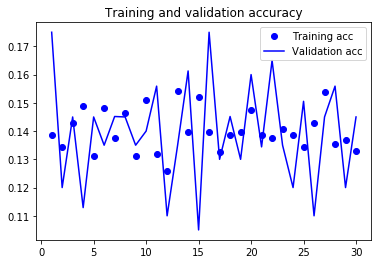

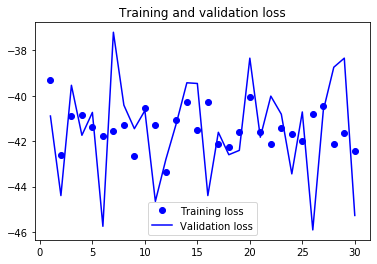

In [0]:
model.save('class.h5')

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()